# Install Libraries

In [ ]:
!pip install ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


# Imports

In [ ]:
import cv2
import numpy as np
import os
import random
import shutil
import matplotlib.pyplot as plt
from roboflow import Roboflow

# Motion Blur Augmentaion

In [ ]:


def apply_motion_blur(image):
    angle = random.uniform(0, 360)  # Random angle between 0 and 360 degrees
    kernel_size = random.choice(range(5, 26, 2))   # Random kernel size between 5 and 25

    """Applies motion blur in a given direction."""
    kernel = np.zeros((kernel_size, kernel_size))
    d = (kernel_size - 1) // 2

    # Create a motion blur kernel
    y, x = np.ogrid[-d:d+1, -d:d+1]
    direction = np.deg2rad(angle)
    mask = np.abs(x * np.cos(direction) + y * np.sin(direction)) < 1
    kernel[mask] = 1
    kernel /= kernel.sum()

    return cv2.filter2D(image, -1, kernel)

def process_image(image_path, label_path, output_dir):
    """Applies motion blur to only the basketball in the image."""
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    # Read the label file
    with open(label_path, 'r') as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        if class_id!=0:
          continue
        xc, yc, bw, bh = map(float, parts[1:])

        # Convert normalized coordinates to pixel values
        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)

        # Extract the basketball region
        ball_region = image[y1:y2, x1:x2]

        # Apply motion blur
        blurred_ball = apply_motion_blur(ball_region)

        # Replace the ball in the original image
        image[y1:y2, x1:x2] = blurred_ball

        # Save the updated annotation
        new_lines.append(line)

    # Save the new image
    filename = os.path.basename(image_path).replace(".jpg", "_blurred.jpg")
    output_image_path = os.path.join(output_dir, "images", filename)
    cv2.imwrite(output_image_path, image)

    # Save the annotation file
    output_label_path = os.path.join(output_dir, "labels", filename.replace(".jpg", ".txt"))
    with open(output_label_path, 'w') as f:
        f.writelines(new_lines)

# YOLO v5

In [ ]:
roboflow_api_key = ""
rf = Roboflow(api_key=roboflow_api_key )
project = rf.workspace("workspace-5ujvu").project("basketball-players-fy4c2-vfsuv")
version = project.version(17)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Basketball-Players-17 in yolov5pytorch:: 100%|██████████| 652/652 [00:00<00:00, 3285.23it/s]


In [ ]:


shutil.move("Basketball-Players-17/train",
"Basketball-Players-17/Basketball-Players-17/train",
)
shutil.move("Basketball-Players-17/valid",
"Basketball-Players-17/Basketball-Players-17/valid",
)

'Basketball-Players-17/Basketball-Players-17/valid'

In [ ]:
input_image_dir = "Basketball-Players-17/Basketball-Players-17/train/images"
input_label_dir = "Basketball-Players-17/Basketball-Players-17/train/labels"
output_dir = "Basketball-Players-17/Basketball-Players-17/train"
os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "labels"), exist_ok=True)

for filename in os.listdir(input_image_dir):
    if filename.endswith(".jpg"):
        image_path = os.path.join(input_image_dir, filename)
        label_path = os.path.join(input_label_dir, filename.replace(".jpg", ".txt"))
        if os.path.exists(label_path):
            process_image(image_path, label_path, output_dir)

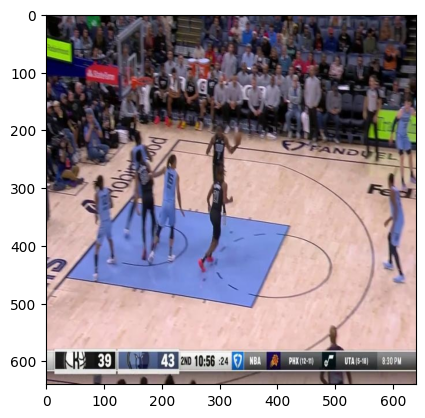

In [ ]:
img = cv2.imread("Basketball-Players-17/Basketball-Players-17/train/images/frame_98845_jpg.rf.da26767bb38594ab42410501be19c7c0_blurred.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [ ]:
!yolo task=detect mode=train model=yolov5l6u.p data={dataset.location}/data.yaml epochs=250 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=best.pt, data=/content/Basketball-Players-17/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0